In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

sns.set_theme()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
air_df = pd.read_csv('international-airline-passengers.csv')

* Посчитаем тест Дики-Фулера для ряда

In [3]:
print('air_df adfuller:', adfuller(air_df['Count'], autolag='AIC')[1])

air_df adfuller: 0.9918802434376409


* Видим, что мы не можем отвергнуть гипотезу о нестационарности ряда, то есть будем рассматривать его как нестационарный
* Тем не менее это не мешает нам применить к нему двоное и тройное экспоненциальное сглаживание

In [6]:
### разобьем на трейн и тест, не теряя исходной временной последовательности ряда
air_df_train, air_df_test = air_df['Count'][:-10], air_df['Count'][-10:]

* Построим двойное экспоненциальное сглаживание, и посчитаем MSE для предсказания

In [4]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    
    for n in range(1, len(series)):
        value = series[n]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        
        trend = beta*(level-last_level) + (1-beta)*trend
        
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds

C:\Users\683A~1\AppData\Local\Temp/ipykernel_3316/2090657853.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds
C:\Users\683A~1\AppData\Local\Temp/ipykernel_3316/2090657853.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds


MSE: 6578.955706514431


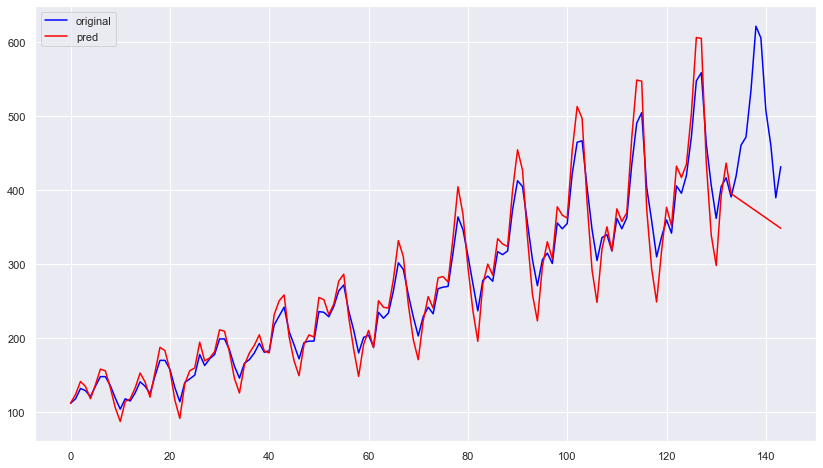

In [7]:
print('MSE:',mean_squared_error(air_df_test,double_ema_with_preds(air_df_train,0.1,0.2,10)[2]))
plt.figure(figsize=(14, 8))
plt.plot(air_df['Count'],color='blue',label='original');
plt.plot(double_ema_with_preds(air_df_train,0.8,0.8,10)[1],color='red',label='pred');
plt.legend();

* Результаты не очень... но для этого и придумали тройное сглаживание, котоое мы построим ниже

In [8]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    
    with plt.style.context('bmh'):
        
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.axvline (x=len(ser.index),ymax=1, color='brown', linestyle='--',label='sep between train and original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

MSE: 3129.5881382325697


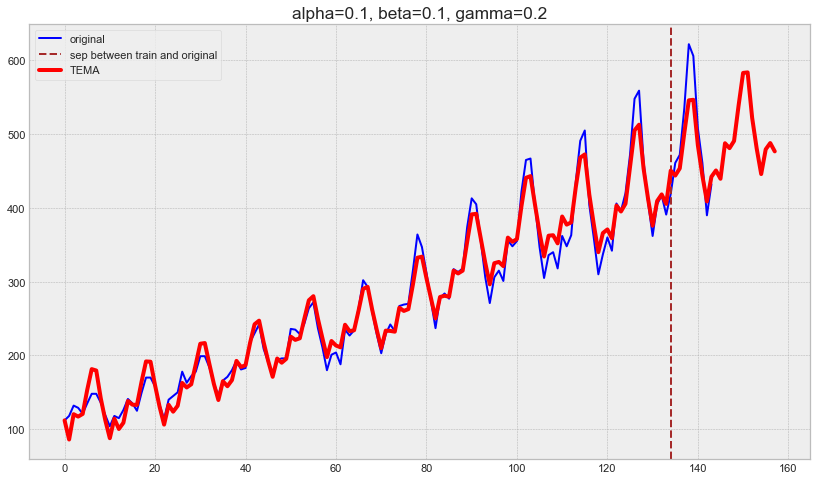

In [9]:
print('MSE:',mean_squared_error(air_df_test,triple_exponential_smoothing(air_df_train, 12, 0.1, 0.1, 0.2, 9)[-10:]))

plot_tema(0.1, 0.1, 0.2,air_df_train,air_df['Count'])

## Итог:
* Тройное сглаживание показало очень неплохие результаты по предсказанию ряда
